Started on 25th Aug 2024



> Pasani S, Sahoo S, Jolly MK. Hybrid E/M Phenotype(s) and Stemness: A Mechanistic Connection Embedded in Network Topology. Journal of Clinical Medicine. 2021; 10(1):60.

https://doi.org/10.3390/jcm10010060



In [ ]:
import pandas as pd

# Read a tab-separated .dat file
df = pd.read_csv('satwik_2020_solution.dat', delimiter='\t', header=None,
names=[' Model_index', 'Number_of_stable_states',
'Runs_converged_to_steady_state', 'mir200', 'ZEB', 'LIN28', 'SNAIL', 'let7', 'NFkB'])

print(df[['mir200', 'ZEB', 'LIN28', 'SNAIL', 'let7', 'NFkB']])

# Z-normalize the expression levels of genes using StandardScaler
from sklearn.preprocessing import StandardScaler # type: ignore

scaler = StandardScaler()
df[['mir200', 'ZEB', 'LIN28', 'SNAIL', 'let7', 'NFkB']] = scaler.fit_transform(df[['mir200', 'ZEB', 'LIN28', 'SNAIL', 'let7', 'NFkB']])

# Display the first few rows of the dfFrame
print(df[['mir200', 'ZEB', 'LIN28', 'SNAIL', 'let7', 'NFkB']])


         mir200        ZEB      LIN28     SNAIL      let7      NFkB
0      0.638922   6.910117   2.970524  6.193735 -6.580512  5.732400
1      6.138154  -3.999013  -5.618410  6.193735 -3.255400  5.732400
2      6.138184  -6.089591 -11.278848  6.193735  3.209627  5.732400
3      0.638991   4.886627  -7.312906  6.193735  3.196871  5.732400
4      5.208685  -9.102998 -11.961062  5.382811  4.433421  6.197452
...         ...        ...        ...       ...       ...       ...
21446  0.956765   6.487005   3.319528  4.793634 -8.432385  6.465114
21447  1.690178   0.814455 -11.959357  4.188499  3.584014  5.856984
21448  7.849857 -10.355522 -14.346720  4.188499  3.584014  5.856984
21449 -5.160090   2.314496  -4.094455  4.723353 -2.718798  5.887085
21450 -0.585508  -7.943970  -7.874068  4.723353  3.483227  5.887085

[21451 rows x 6 columns]
         mir200       ZEB     LIN28     SNAIL      let7      NFkB
0     -0.355626  1.258502  0.754498  1.253771 -1.154976 -0.457221
1      1.055314 -0.309018 

In [ ]:
!pip install fastcluster

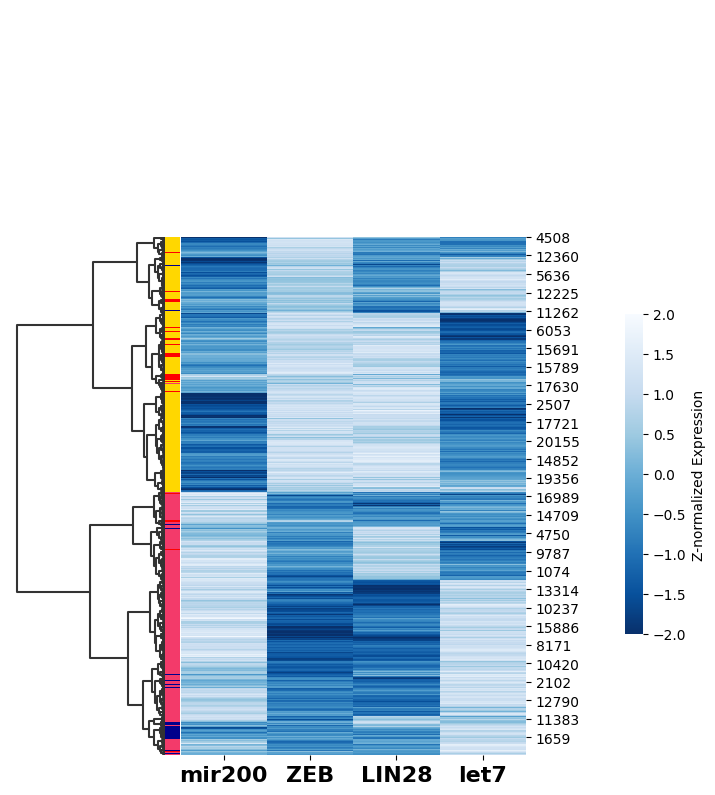

In [ ]:
"""
If you expect clusters of roughly equal size and want to minimize within-cluster variance: Use method='ward' and metric='euclidean'.
If you are interested in capturing patterns of co-expression and want to be less sensitive to absolute expression differences: Use method='average' or method='complete' with metric='correlation'.
If you suspect outliers in your data and want to create compact clusters: Use method='complete' with metric='euclidean'.
"""
import seaborn as sns
import matplotlib.pyplot as plt
import fastcluster
import numpy as np

# Calculate medians
mir200_median = df['mir200'].median()
ZEB_median = df['ZEB'].median()

# Create color mappings
row_colors = []
for _, row in df.iterrows():
    if row['mir200'] >= mir200_median and row['ZEB'] >= ZEB_median:
        row_colors.append('red')  # High mir200, High ZEB
    elif row['mir200'] >= mir200_median and row['ZEB'] < ZEB_median:
        row_colors.append('#F33A6A') # High mir200, Low ZEB
    elif row['mir200'] < mir200_median and row['ZEB'] >= ZEB_median:
        row_colors.append('gold') # Low mir200, High ZEB
    else:
        row_colors.append('#00008B') # Low mir200, Low ZEB

# Create the clustermap with hierarchical clustering and row colors
g = sns.clustermap(
    df[['mir200', 'ZEB', 'LIN28', 'let7']],
    method='ward',
    metric='euclidean',
    cmap= 'Blues_r',
    vmin= -2,
    vmax= 2,
    standard_scale=None,
    figsize=(6, 8),
    cbar_kws={"label": "Z-normalized Expression"},
    cbar_pos=(1.05, .2, .03, .4),
    row_colors=row_colors, # Add row colors
    dendrogram_ratio=(0.3, 0.3),
    tree_kws={"linewidths": 1.5},
    col_cluster=False
)

# Access the axes object
ax = g.ax_heatmap

# Set font properties for xticklabels (column dendrogram)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=16, rotation=0)

plt.show()


In [ ]:
import scipy.cluster.hierarchy as sch
import fastcluster

# Extract the relevant columns for clustering
data = df[['mir200', 'ZEB', 'LIN28', 'let7']]

# Perform agglomerative hierarchical clustering
distance_matrix = fastcluster.linkage(data, method='ward', metric='euclidean')

# Determine cluster assignments
cluster_assignments = sch.cut_tree(distance_matrix, n_clusters=4)

# Add cluster assignments to the DataFrame
df['Cluster'] = cluster_assignments.flatten()

print(df)


        Model_index  Number_of_stable_states  Runs_converged_to_steady_state  \
0                 1                        4                              44   
1                 1                        4                              41   
2                 1                        4                              12   
3                 1                        4                               3   
4                 2                        3                              50   
...             ...                      ...                             ...   
21446          9998                        3                              35   
21447          9999                        2                              43   
21448          9999                        2                              57   
21449         10000                        2                              67   
21450         10000                        2                              33   

         mir200       ZEB     LIN28    

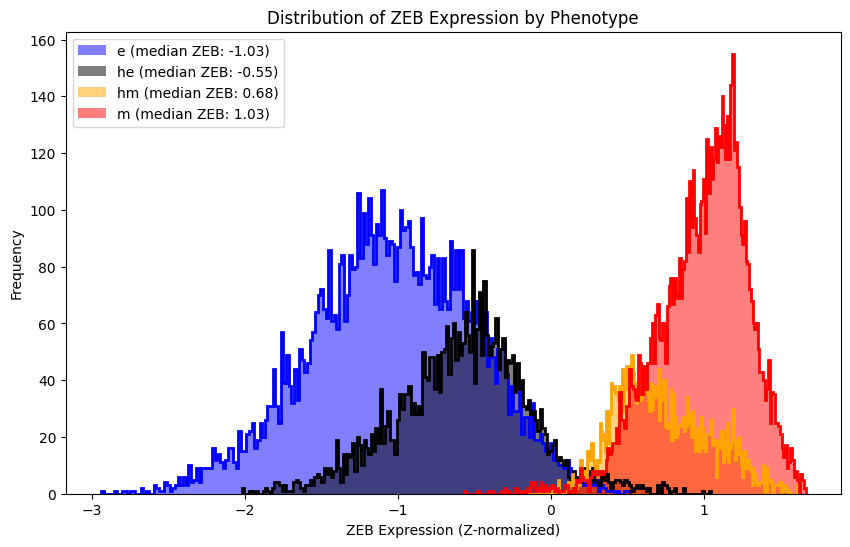

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate median ZEB levels for each cluster
median_zeb_by_cluster = df.groupby('Cluster')['ZEB'].median().sort_values()

# Assign phenotypes based on median ZEB levels
phenotypes = ['e', 'he', 'hm', 'm']
cluster_to_phenotype = dict(zip(median_zeb_by_cluster.index, phenotypes))
df['Phenotype'] = df['Cluster'].map(cluster_to_phenotype)

# Plot histograms
plt.figure(figsize=(10, 6))
colors = ['blue', 'black', 'orange', 'red']

for phenotype, color in zip(phenotypes, colors):
    subset = df[df['Phenotype'] == phenotype]
    plt.hist(subset['ZEB'], bins=200, alpha = 0.5, label=f'{phenotype} (median ZEB: {subset["ZEB"].median():.2f})', color=color)

# Plot step histogram
for phenotype, color in zip(phenotypes, colors):
  subset = df[df['Phenotype'] == phenotype]
  plt.hist(subset['ZEB'], bins=200, histtype='step', linewidth=2, color=color)

plt.xlabel('ZEB Expression (Z-normalized)')
plt.ylabel('Frequency')
plt.title('Distribution of ZEB Expression by Phenotype')
plt.legend()
plt.show()

In [ ]:
median_zeb_by_cluster = df.groupby('Cluster')['ZEB'].median().sort_values()

print(median_zeb_by_cluster)

Cluster
2   -1.027063
1   -0.551256
3    0.680542
0    1.031051
Name: ZEB, dtype: float64


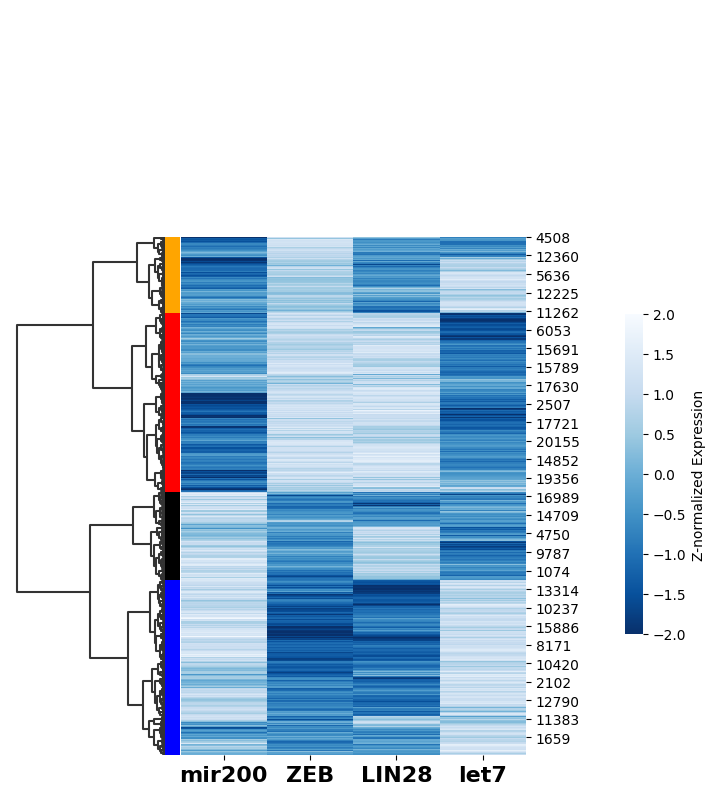

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import fastcluster
import numpy as np

color_mapping = {2:'blue', 1:'black', 3:'orange', 0:'red'}
row_colors = [color_mapping[label] for label in cluster_assignments.flatten()]

# Create the clustermap with hierarchical clustering
g = sns.clustermap(
    df[['mir200', 'ZEB', 'LIN28', 'let7']],
    method='ward',
    metric='euclidean',
    cmap='Blues_r',
    vmin=-2,
    vmax=2,
    standard_scale=None,
    figsize=(6, 8),
    cbar_kws={"label": "Z-normalized Expression"},
    cbar_pos=(1.05, .2, .03, .4),
    row_colors=row_colors, # Add row colors
    dendrogram_ratio=(0.3, 0.3),
    tree_kws={"linewidths": 1.5},
    col_cluster=False
)
ax = g.ax_heatmap

ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold', fontsize=16, rotation=0)

plt.show()

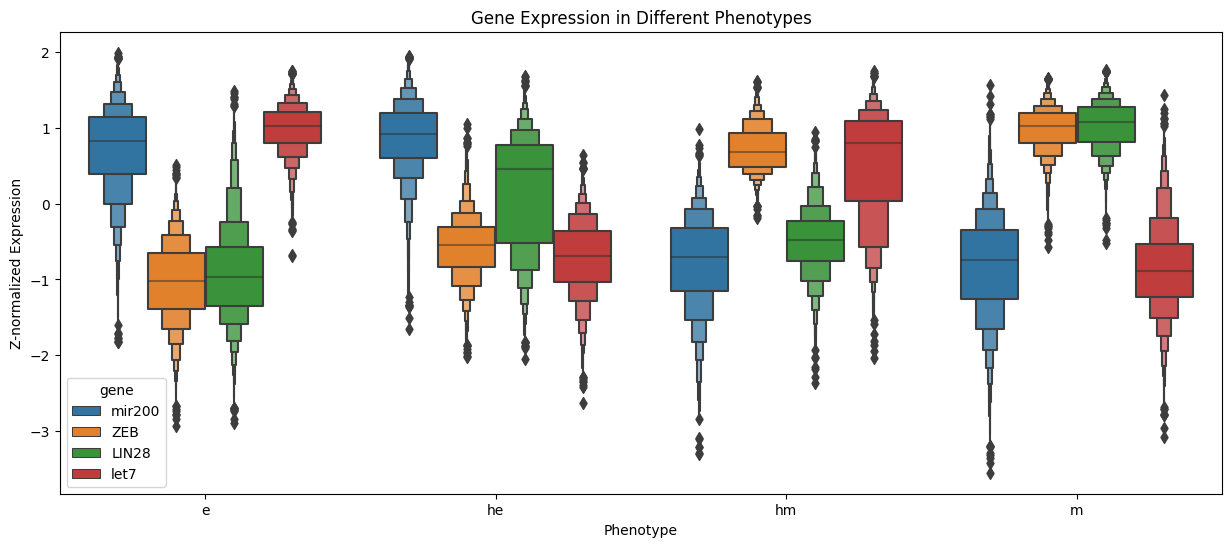

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df['phenotype'] = ['m' if label == 0 else 'he' if label == 1 else 'e' if label == 2 else 'hm' for label in cluster_assignments.flatten()]

df_melt = pd.melt(df, id_vars=['phenotype'], value_vars=['mir200', 'ZEB', 'LIN28', 'let7'], var_name='gene', value_name='expression')

phenotype_order = ['e', 'he', 'hm', 'm']

# Create the boxen plots
plt.figure(figsize=(15, 6))
sns.boxenplot(x='phenotype', y='expression', hue='gene', order = phenotype_order, data=df_melt, dodge = True)

plt.title('Gene Expression in Different Phenotypes')
plt.xlabel('Phenotype')
plt.ylabel('Z-normalized Expression')
plt.show()

Explained Variance Ratio: [0.4746098  0.19269839 0.17747755 0.09573668 0.03357599 0.02590159]


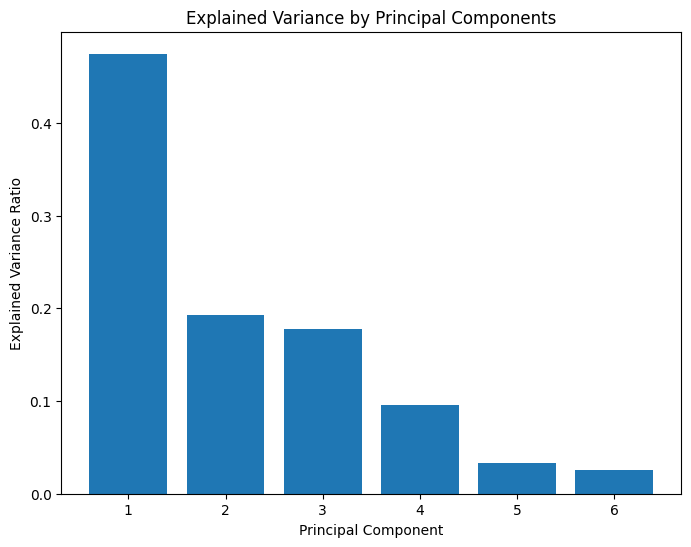

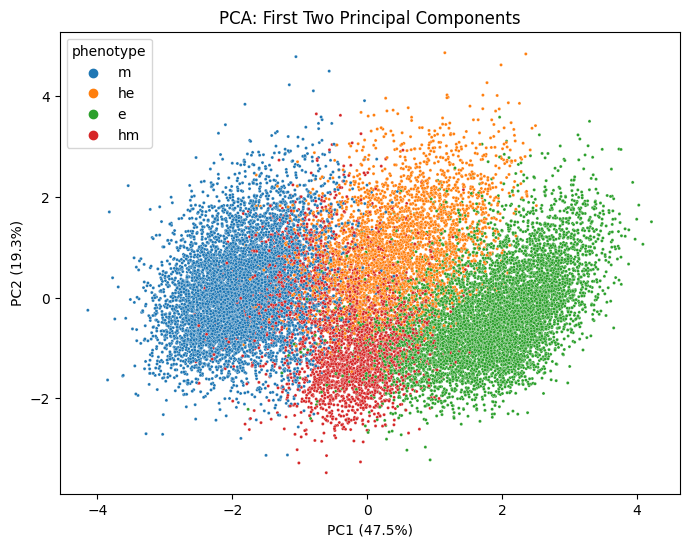

In [ ]:
from sklearn.decomposition import PCA

# Extract the relevant columns for PCA
data_pca = df[['mir200', 'ZEB', 'LIN28', 'SNAIL', 'let7', 'NFkB']]

# Initialize PCA object
pca = PCA()

# Fit PCA to the data
pca.fit(data_pca)

# Transform the data to the principal component space
principal_components = pca.transform(data_pca)

# Create a DataFrame with the principal components
pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# Add the phenotype information to the PC DataFrame
pc_df['phenotype'] = df['phenotype']

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.show()

# Scatter plot of the first two principal components
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='phenotype', data=pc_df, s=5)
plt.title('PCA: First Two Principal Components')
plt.xlabel(f'PC1 ({explained_variance_ratio[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]*100:.1f}%)')
plt.show()
